# Basic Analyses:
  
To-DO: 
- decide which subjects to exclude. 

- replot the regression coefficients. 
- correlate intercept model parameters across sessions 
- read in the stai data.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns


In [55]:
import sys
sys.path.append("../functions/")
#for data preprocessing
import Scripts_Data_Processing
import imp

imp.reload(Scripts_Data_Processing)
from Scripts_Data_Processing import *
#for model fit
import Scripts_LogRegModels_v2
imp.reload(Scripts_LogRegModels_v2)
from Scripts_LogRegModels_v2 import *

import NoBrainer_Analysis_AllinOne
imp.reload( NoBrainer_Analysis_AllinOne)
from  NoBrainer_Analysis_AllinOne import *

import Correlation_bw_triplets
imp.reload( Correlation_bw_triplets)
from  Correlation_bw_triplets import *

# gainloss load in single subjectdata + nobrainer

In [3]:
df_list = []
vp_perform_gainloss_list = []
vp_nb_gainloss_list = []
vp_list = ['06', '07', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '22', '23_2', '25_2', '26_2', '27_2', '28_2', '29', '30']
for vp in vp_list:
    path = os.path.join(os.getcwd(),'..','data','data_gainloss_logfiles','vp' + vp + '_gainloss_processed.csv')
    df = pd.read_csv(path, sep=",")
    #preprocess gainloss data
    df=preprocess_gainloss(df)
    #preprocess data
    df = preprocess(df)
    #store prepocessed data in list that contains data for all subjects (for later analysis)
    df_list.append(df)
    #create subset with unambiguous trials for no brainer analysis
    nb_df = drop_ambi_trials(df)
    #create variables indicating whether left or right was the better option
    better_choice_gainloss(nb_df)
    #indicate whether the better box was chosen
    nb_df = right_choice(nb_df)
    #only keep trials that are 'no brainers'
    nb_df = keep_nobrainers(nb_df)
    #calculate performance
    vp_perform_gainloss = ['vp' + vp, vp_perf(nb_df)]
    #store each vp performance in list
    vp_perform_gainloss_list.append(vp_perform_gainloss)
    #vp performance sectionwise
    vp_nb_gainloss = nb_df.groupby('section').mean().add_prefix('gainloss_')[['gainloss_choseBetter']]
    vp_nb_gainloss['MID'] = 'vp'+ vp
    vp_nb_gainloss_list.append(vp_nb_gainloss)
    
#make dataframe for nb performance
nobrainer_gainloss = pd.DataFrame(vp_perform_gainloss_list,columns=['MID','nbperf'])

#dataframe for single subject (last one) to try out code
gainloss_ls_df = df


../functions/NoBrainer_Analysis_AllinOne.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['left_better']=left_better
../functions/NoBrainer_Analysis_AllinOne.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['right_better']=right_better
../functions/NoBrainer_Analysis_AllinOne.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

In [ ]:
vp_nb_gainloss_list[1:2]

## Create preprocessed dataframe with all vp

In [4]:
#Merge dataframe list to single dataframe. "inner": Just take columns which exist in all dataframes    
gainloss_df = pd.concat(df_list, ignore_index = True, join = 'inner')  

In [ ]:
print(len(gainloss_df))
gainloss_df.head(5)

## Gain/Loss Model fit - individual subjects

In [5]:
param_sets_split = {}
param_sets_split['0'] = ['mag_diff','prob_diff']
param_sets_split['1'] = ['mag_diff','prob_diff','ambiguityLevel']

In [6]:
vp_list = ['06','07','10','11', '12', '13', '15', '16', '17', '18', '19', '20', '22', '23_2', '25_2', '26_2', '27_2', '28_2', '29', '30']
resultnames = ['bic','aic','pseudoR2','pred_acc', 'llr_pvalue']
model_param_df = np.array(['','','',3.0,3.0])
model_summary_df = nobrainer_gainloss

for vp in vp_list:
    
    df = gainloss_df[gainloss_df.MID == 'vp' + vp]
    MID = 'vp' + vp
        
    for split in ['ambig_gain','ambig_loss','unambig_gain','unambig_loss']:
        if 'unambig' in split:
            paramnum='0'
        else:
            paramnum='1'
            
        # Fit a model to each set of trials 
        out = fit_model_split_amb_unamb_gain_loss(df, whichreturn= split, params=param_sets_split[paramnum],zscore=True)
        
        modelname = out['modelname']

        for result in resultnames:
            model_summary_df.loc[(model_summary_df.MID== 'vp' + vp),result+'_'+split]=out[result]

        params = out['params']
        se=out['se']
        for param in params.index:
            paramn = param.replace('_loss','')
            paramn = paramn.replace('_gain','')
            paramn = paramn.replace('_amb','')
            paramn = paramn.replace('_rl','')
            row = np.array([MID,paramn,split,params[param],se[param]])
            model_param_df=np.vstack((model_param_df,row))

model_param_df = pd.DataFrame(model_param_df,columns=['MID','parameter','split','beta','se'])
model_param_df.drop(0,inplace=True) #df.index[0]
model_param_df['beta']=model_param_df['beta'].astype('float')
model_param_df_gainloss = model_param_df



In [ ]:
print(out['aic'])
print(out['pred_acc'])
print(out['modelname'])
out['results'].summary()



### scatterplot for model fit and significance

C:\Users\Hanna\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


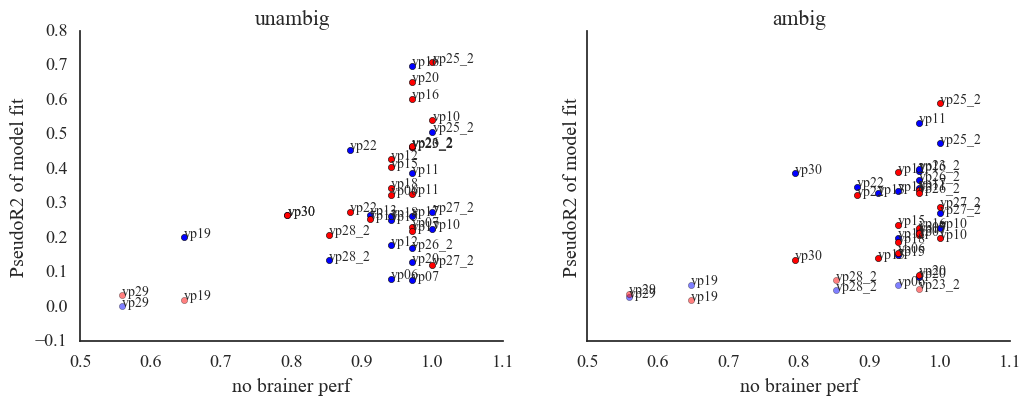

In [7]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", family="Times New Roman")
sns.set_context('talk')
fig,axes =plt.subplots(1,2, figsize=(12,4),sharey=True,sharex=True)

MIDS = model_summary_df.MID
NB = model_summary_df['nbperf']
for tt,trial_type in enumerate(['unambig','ambig']):
    for task in ['gain','loss']:
        R2 = model_summary_df['pseudoR2_'+trial_type+'_'+task]
        pvals = model_summary_df['llr_pvalue_'+trial_type+'_'+task]
        color ='b' if task=='gain' else 'r'

        for r,n,p,mid in zip(R2,NB,pvals,MIDS):
            alpha=1.0 if p<0.05 else 0.5
            axes[tt].scatter(n,r, c=color,alpha=alpha)
            axes[tt].annotate(mid,(n,r),fontsize=10)
    axes[tt].set_xlabel('no brainer perf')
    axes[tt].set_ylabel('PseudoR2 of model fit')
    axes[tt].set_title(trial_type)
sns.despine()
plt.legend()


- what the hell is going on with the subjects that have .95 no brainer and <0.1 R2. 


### bargraph for parameters

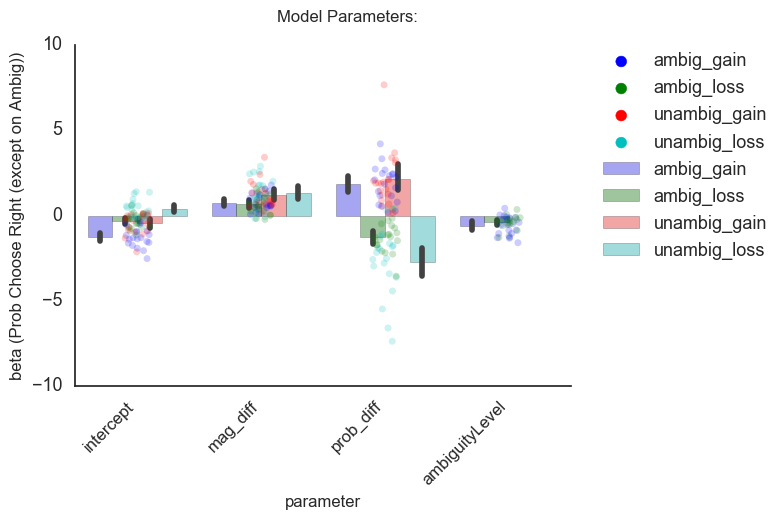

In [8]:
fig = plot_params(model_param_df_gainloss, stripplot=True)

# shock load in single subjectdata + nobrainer

In [9]:
df_list = []
vp_list = ['06', '07', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '22', '23', '25', '26', '27', '28', '29', '30']
vp_perform_shock_list = []
vp_nb_shock_list = []
section_list = ['1', '2', '3']
for vp in vp_list:
    df = []
    for sec in section_list:
        path = os.path.join(os.getcwd(),'..','data','data_shock_logfiles','Expt1Pain_Behaviour_vp' + vp + '_' + sec + '.txt')
        df_dummy = pd.read_csv(path, sep="\t", skiprows = [0])
        df_dummy = df_dummy[:-1] #deletes last row of each section as it does not contain trial data
        df_dummy['MID'] = 'vp'+ vp
        df_dummy['section'] = sec
        df_dummy.columns = df_dummy.columns.str.replace(' ','')
        df.append(df_dummy)
    
    #create a df that contains data from all sections    
    df = pd.concat(df, ignore_index = True, join = 'inner')
    #preprocess shock data
    df = preprocess_shock(df)
    #preprocess data
    df = preprocess(df)
    #store prepocessed data in list that contains data for all subjects (for later analysis)
    df_list.append(df)
    #create subset with unambiguous trials for no brainer analysis
    nb_df = drop_ambi_trials(df)
    #create variables indicating whether left or right was the better option
    better_choice_shock(nb_df)
    #indicate whether the better box was chosen
    nb_df = right_choice(nb_df)
    #only keep trials that are 'no brainers'
    nb_df = keep_nobrainers(nb_df)
    #calculate performance
    vp_perform_shock = ['vp' + vp, vp_perf(nb_df)]
    #store each vp performance in list
    vp_perform_shock_list.append(vp_perform_shock)
    #vp performance sectionwise
    vp_nb_shock = nb_df.groupby('section').mean().add_prefix('shock_')[['shock_choseBetter']]
    vp_nb_shock['MID'] = 'vp'+ vp
    vp_nb_shock_list.append(vp_nb_shock)
    
#make dataframe for nb performance
nobrainer_shock = pd.DataFrame(vp_perform_shock_list,columns=['MID','nbperf'])

#dataframe for single subject (last one) to try out code
shock_ls_df = df

../functions/NoBrainer_Analysis_AllinOne.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['left_better']=lb
../functions/NoBrainer_Analysis_AllinOne.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['right_better']=rb


In [ ]:
vp_nb_shock_list[1:2]

## Create preprocessed dataframe with all vp

In [11]:
#create complete df for shock condition with all vps        
shock_df = pd.concat(df_list, ignore_index = True, join = 'inner')

## Shock: Model fit


In [12]:
vp_list = ['06', '07', '10', '11' ,'12', '13', '15', '16', '17', '18', '19', '20', '22', '23', '25', '26', '27', '28', '29', '30']
resultnames = ['bic','aic','pseudoR2','pred_acc', 'llr_pvalue'] 
model_param_df = np.array(['','','',3.0, 3.0])
model_summary_df = nobrainer_shock

for vp in vp_list:
    
    df = shock_df[shock_df.MID == 'vp' + vp]
    MID = 'vp' + vp
        
    for split in ['ambig_shock','unambig_shock']:
        #print(split)
        if 'unambig' in split:
            paramnum='0'
        else:
            paramnum='1'
        # Fit a model to the ambiguous gain trials 
        out = fit_model_split_amb_unamb_gain_loss(df, whichreturn= split, params=param_sets_split[paramnum],zscore=True)
        
    
        modelname = out['modelname']

        for result in resultnames:
            model_summary_df.loc[(model_summary_df.MID== 'vp' + vp),result+'_'+split]=out[result]

        params = out['params']
        se = out['se']
        for param in params.index:
            paramn = param.replace('_gain','')
            paramn = paramn.replace('_amb','')
            paramn = paramn.replace('_rl','')
            row = np.array([MID,paramn,split,params[param],se[param]])
            model_param_df=np.vstack((model_param_df,row))

model_param_df = pd.DataFrame(model_param_df,columns=['MID','parameter','split','beta', 'se'])
model_param_df.drop(0,inplace=True) #df.index[0]
model_param_df['beta']=model_param_df['beta'].astype('float')
model_param_df_shock = model_param_df        

   

In [ ]:
print(out['aic'])
print(out['pred_acc'])
print(out['modelname'])
out['results'].summary()
    

### scatterplot for model fit and significance

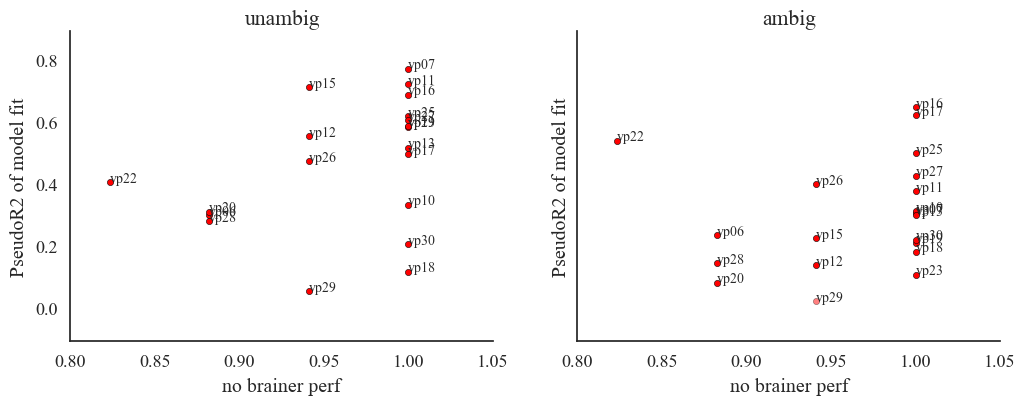

In [13]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", family="Times New Roman")
sns.set_context('talk')
fig,axes =plt.subplots(1,2, figsize=(12,4),sharey=True,sharex=True)

MIDS = model_summary_df.MID
NB = model_summary_df['nbperf']
for tt,trial_type in enumerate(['unambig','ambig']):
    for task in ['shock']:
        R2 = model_summary_df['pseudoR2_'+trial_type+'_'+task]
        pvals = model_summary_df['llr_pvalue_'+trial_type+'_'+task]
        color ='b' if task=='gain' else 'r'

        for r,n,p,mid in zip(R2,NB,pvals,MIDS):
            alpha=1.0 if p<0.05 else 0.5
            axes[tt].scatter(n,r, c=color,alpha=alpha)
            axes[tt].annotate(mid,(n,r),fontsize=10)
    axes[tt].set_xlabel('no brainer perf')
    axes[tt].set_ylabel('PseudoR2 of model fit')
    axes[tt].set_title(trial_type)
sns.despine()
plt.legend()

### bargraph for parameters

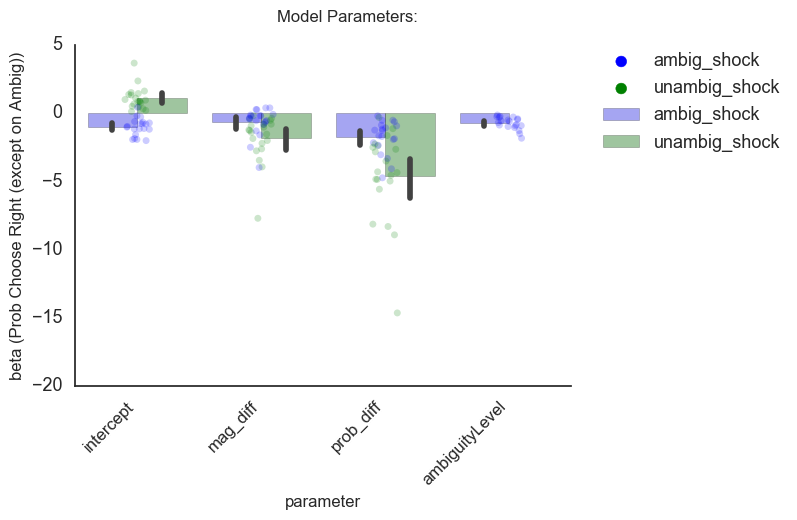

In [14]:
fig = plot_params(model_param_df_shock, stripplot=True)

- remove bad fitting subjects - vp19 and vp29

In [15]:
print(len(model_param_df_shock))
model_param_df_shock = model_param_df_shock.loc[model_param_df_shock['MID']!='vp29',]
model_param_df_shock = model_param_df_shock.loc[model_param_df_shock['MID']!='vp19',]
print(len(model_param_df_shock))

140
126


In [16]:
print(len(model_param_df_gainloss))
model_param_df_gainloss = model_param_df_gainloss.loc[model_param_df_gainloss['MID']!='vp29',]
model_param_df_gainloss = model_param_df_gainloss.loc[model_param_df_gainloss['MID']!='vp19',]
print(len(model_param_df_gainloss))

280
252


# Traits 

# Correlation across Dataset

In [17]:
model_param_df_merged = pd.concat((model_param_df_gainloss,model_param_df_shock))
model_param_df_merged.head()

,MID,parameter,split,beta,se
1,vp06,intercept,ambig_gain,-1.759563,0.343866292919
2,vp06,mag_diff,ambig_gain,0.362886,0.373872390106
3,vp06,prob_diff,ambig_gain,0.618895,0.39654069989
4,vp06,ambiguityLevel,ambig_gain,-0.476255,0.306502282594
5,vp06,intercept,ambig_loss,0.111916,0.25354260985


In [18]:
#change MIDs to match between gainloss and shock versions
model_param_df_merged.MID = model_param_df_merged.MID.apply(lambda x: x.replace('_2', ''))

### adjust error bars to account for within subject variable

In [ ]:
# smean = triplet_df.mean(axis=1).values
# triplet_df['shock'] = triplet_df['shock']-smean
# triplet_df['gain'] = triplet_df['gain']-smean
# triplet_df['loss'] = triplet_df['loss']-smean

### create tables for each parameter per subject and task

In [19]:
triplet_intercept = triplet(model_param_df_merged, 'intercept', ambiguous=True)
triplet_magdiff = triplet(model_param_df_merged, 'mag_diff', ambiguous=True)
triplet_probdiff = triplet(model_param_df_merged, 'prob_diff', ambiguous=True)
triplet_ambiguityLevel = triplet(model_param_df_merged, 'ambiguityLevel', ambiguous=True)

### plot individual parameter per task

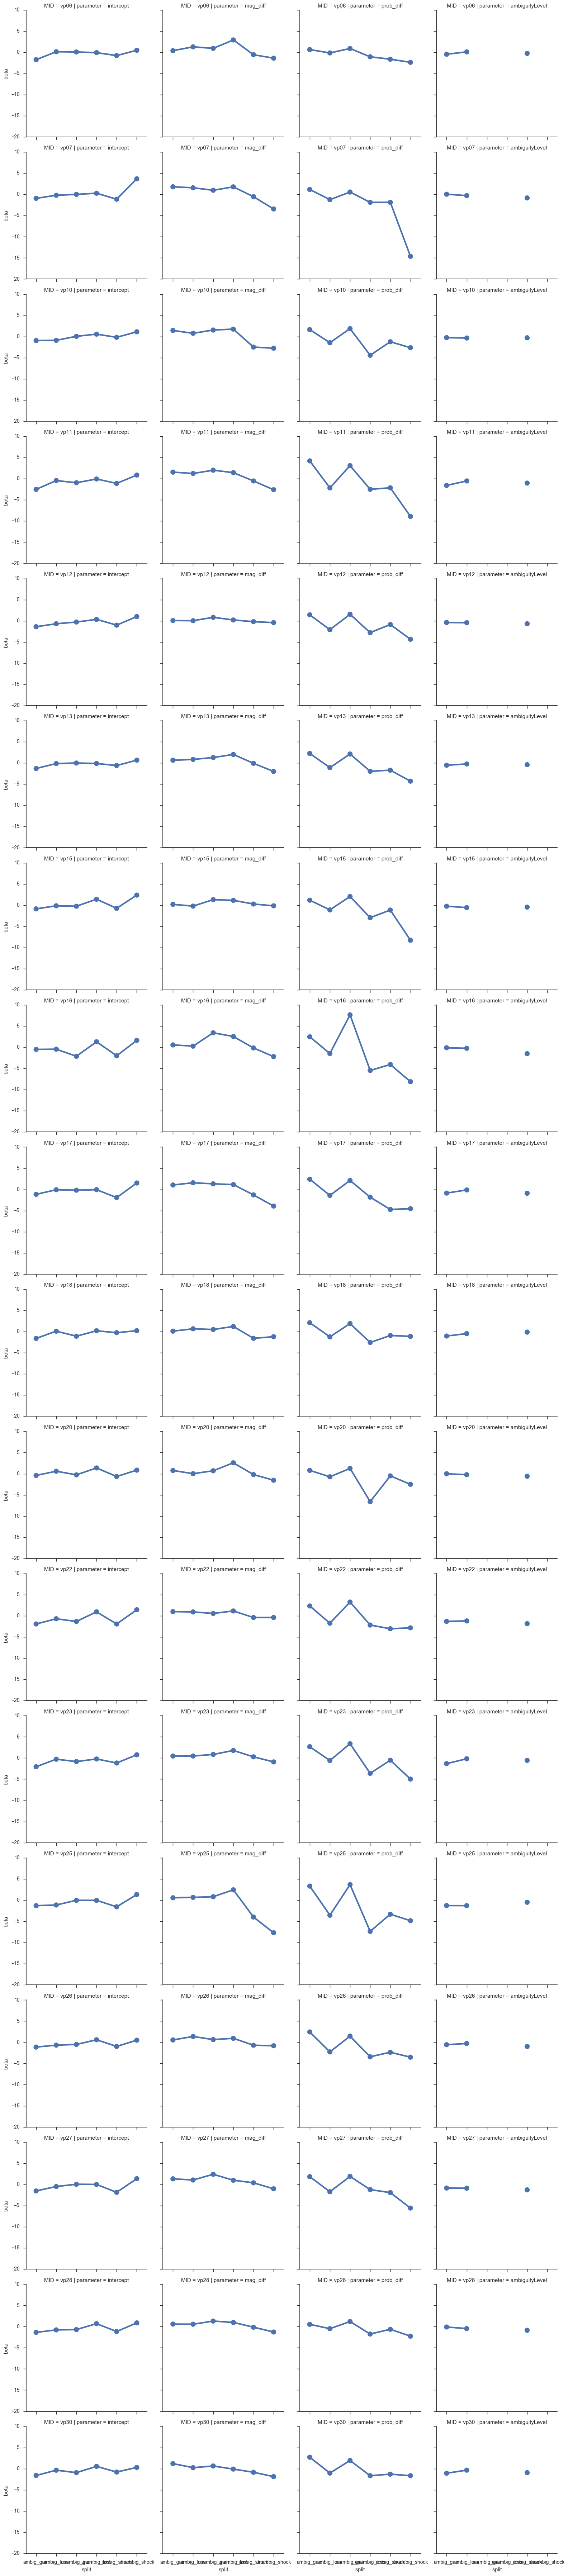

In [20]:
sns.set(style="ticks")
#model_param_df_merged = sns.load_dataset("model_param_df_merged")
g = sns.factorplot(x="split", y="beta", col="parameter", row="MID", data=model_param_df_merged)

### plot mean parameter per task

<Container object of 3 artists>

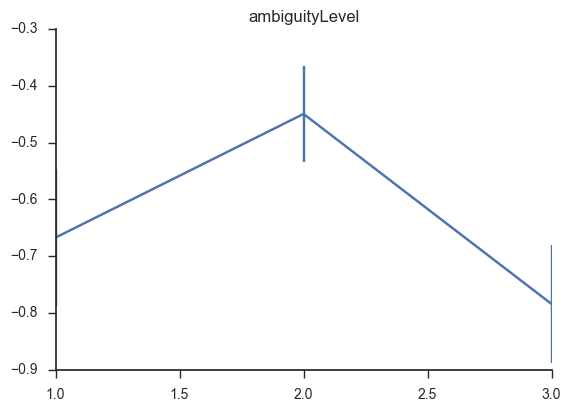

In [50]:
triplet_ambiLevel = triplet(model_param_df_merged, 'ambiguityLevel')
plotTripletAllSubs(triplet_ambiLevel, 'ambiguityLevel')

<Container object of 3 artists>

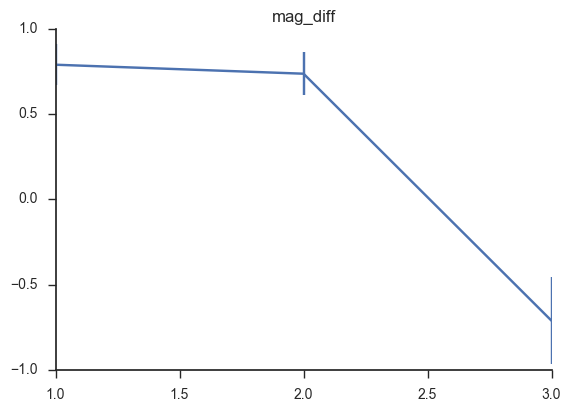

In [51]:
triplet_magdiff = triplet(model_param_df_merged, 'mag_diff')
plotTripletAllSubs(triplet_magdiff, 'mag_diff')

<Container object of 3 artists>

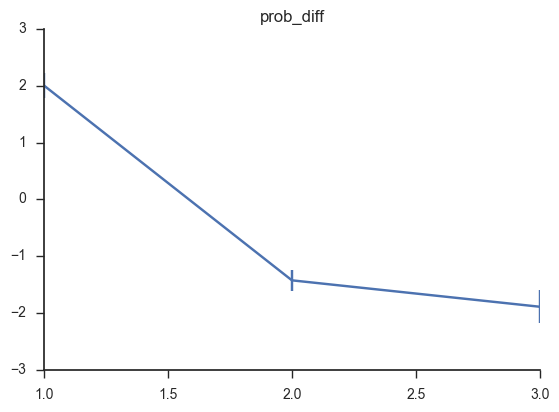

In [52]:
triplet_probdiff = triplet(model_param_df_merged, 'prob_diff')
plotTripletAllSubs(triplet_probdiff, 'prob_diff')

<Container object of 3 artists>

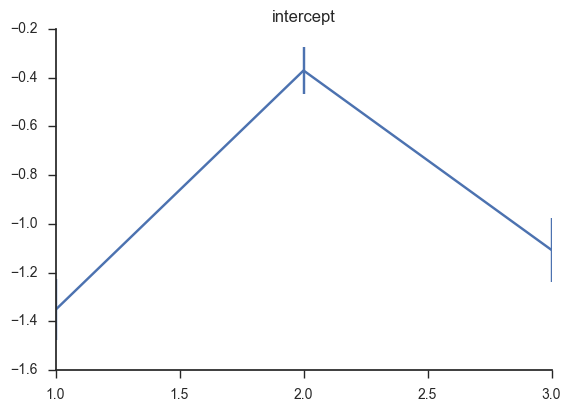

In [53]:
triplet_intercept = triplet(model_param_df_merged, 'intercept')
plotTripletAllSubs(triplet_intercept, 'intercept')

In [ ]:
### plot scatterplot showing the spearman correlation (r and pvalue) of tasks for each parameter

In [54]:
triplet_ambiLevel.head()

,MID,gain,se_gain,loss,se_loss,shock,se_shock
0,vp06,-0.476255,0.306502282594,0.073955,0.251623764192,-0.279013,0.283444815951
1,vp07,0.034741,0.296324313582,-0.299967,0.272134781773,-0.842954,0.325147463569
2,vp10,-0.267383,0.298113132023,-0.355839,0.27764668859,-0.305066,0.294028147747
3,vp11,-1.596625,0.551662139048,-0.539111,0.317940523918,-1.047739,0.359531479641
4,vp12,-0.403651,0.299441465685,-0.452794,0.315260657289,-0.686292,0.273833488002


### function to work on for plots (not in .py yet)
 - errorbars don't work yet. They have to be specified differently and I couldn't find out how
 - diagonal lines

In [99]:

def plotTriplet(triplet_df, parameter):
    #yerr = triplet_df['se_shock']
    #xerr = triplet_df['se_gain']
    fig,axes = plt.subplots(1,3,figsize=(12,4),sharey=True,sharex=True)
    axes[0].scatter(triplet_df['gain'],triplet_df['shock'])
    #axes[0].errorbar(triplet_df['gain'],triplet_df['shock'], xerr=xerr, yerr=yerr)
    axes[0].axhline(y=0.000,c="blue",linewidth=0.5,zorder=0)
    axes[0].axvline(x=0.000,c="blue",linewidth=0.5,zorder=0)


    
    axes[0].set_xlabel('gain')
    axes[0].set_ylabel('shock')
    r,p=spearmanr(triplet_df['gain'],triplet_df['shock'])
    axes[0].set_title('gain/shock r={0} p={1}'.format(np.round(r,2),np.round(p,2)))
    #axes[0].set_xlim([-4,4])
    #axes[0].set_ylim([-4,4])
    axes[0].set_aspect('equal')

    axes[1].scatter(triplet_df['gain'],triplet_df['loss'])
    axes[1].axhline(y=0.000,c="blue",linewidth=0.5,zorder=0)
    axes[1].axvline(x=0.000,c="blue",linewidth=0.5,zorder=0)
    axes[1].set_xlabel('gain')
    axes[1].set_ylabel('loss')
    r,p=spearmanr(triplet_df['gain'],triplet_df['loss'])
    axes[1].set_title('gain/loss r={0} p={1}'.format(np.round(r,2),np.round(p,2)))
    axes[1].set_aspect('equal')

    axes[2].scatter(triplet_df['shock'],triplet_df['loss'])
    axes[2].axhline(y=0.000,c="blue",linewidth=0.5,zorder=0)
    axes[2].axvline(x=0.000,c="blue",linewidth=0.5,zorder=0)
    axes[2].set_xlabel('shock')
    axes[2].set_ylabel('loss')
    r,p=spearmanr(triplet_df['shock'],triplet_df['loss'])
    axes[2].set_title('shock/loss r={0} p={1}'.format(np.round(r,2),np.round(p,2)))
    axes[2].set_aspect('equal')
    sns.despine()

    fig.suptitle(parameter)
    fig.subplots_adjust(top=0.77)

    return(fig)

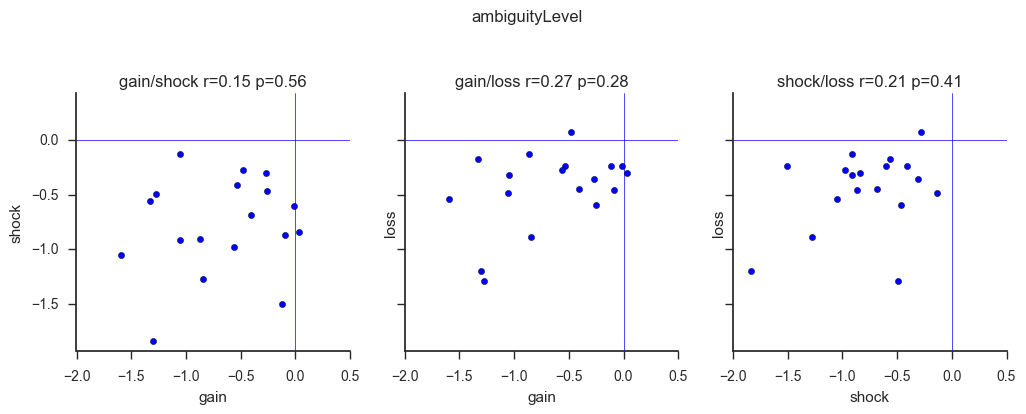

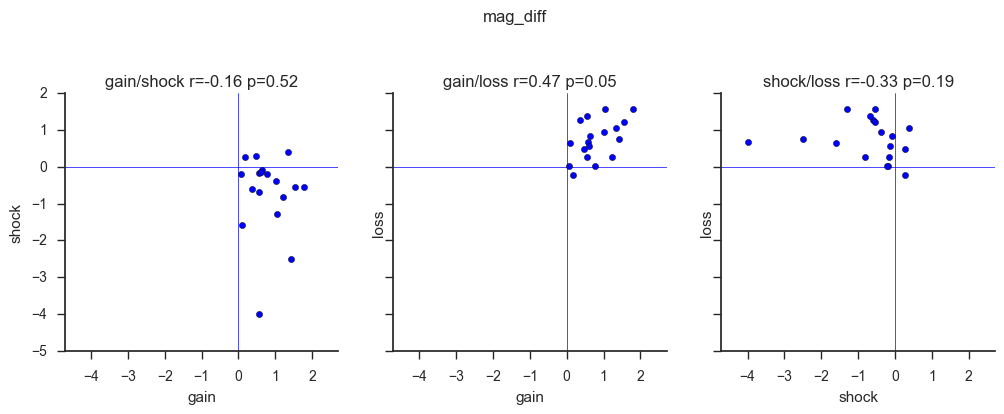

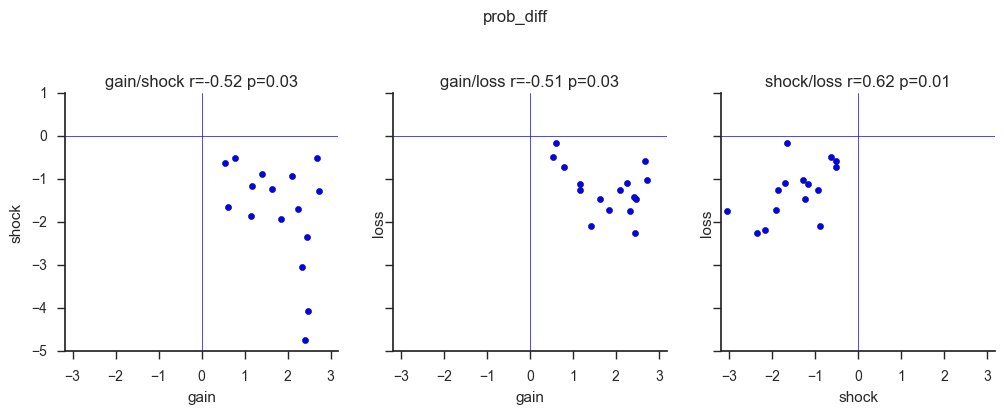

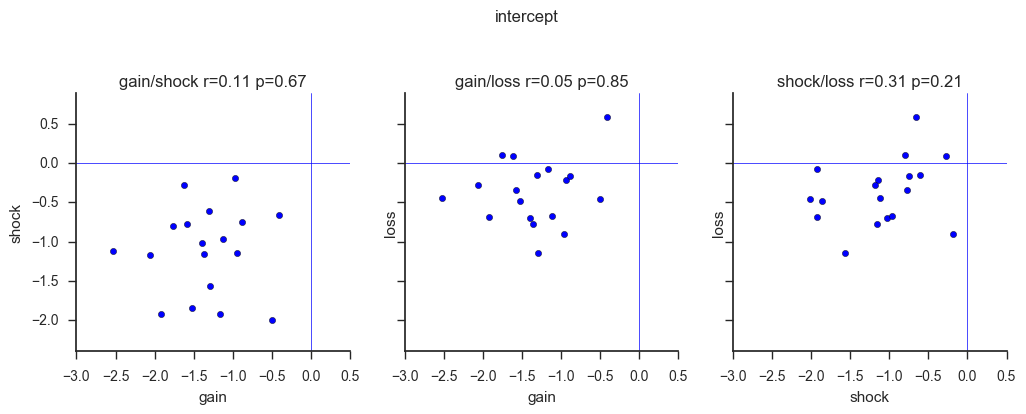

In [101]:
plotTriplet(triplet_ambiLevel, 'ambiguityLevel')
plotTriplet(triplet_magdiff, 'mag_diff')
plotTriplet(triplet_probdiff, 'prob_diff')
f=plotTriplet(triplet_intercept, 'intercept')


### subject count per order of task

In [ ]:
def count_order(triplet_df):

    triplet_df['order'] = np.nan

    triplet_df.loc[(triplet_df['gain'] > triplet_df['loss']) & (triplet_df['loss'] > triplet_df['shock']) & (triplet_df['gain'] > triplet_df['shock']), 'order'] = 'gls'

    triplet_df.loc[(triplet_df['gain'] > triplet_df['loss']) & (triplet_df['loss'] < triplet_df['shock']) & (triplet_df['gain'] > triplet_df['shock']), 'order'] = 'gsl'

    triplet_df.loc[(triplet_df['loss'] > triplet_df['gain']) & (triplet_df['gain'] > triplet_df['shock']) & (triplet_df['loss'] > triplet_df['shock']), 'order'] = 'lgs'

    triplet_df.loc[(triplet_df['loss'] > triplet_df['gain']) & (triplet_df['gain'] < triplet_df['shock']) & (triplet_df['loss'] > triplet_df['shock']), 'order'] = 'lsg'

    triplet_df.loc[(triplet_df['shock'] > triplet_df['gain']) & (triplet_df['gain'] > triplet_df['loss']) & (triplet_df['loss'] < triplet_df['shock']), 'order'] = 'sgl'

    triplet_df.loc[(triplet_df['shock'] > triplet_df['gain']) & (triplet_df['gain'] < triplet_df['loss']) & (triplet_df['loss'] < triplet_df['shock']), 'order'] = 'slg'

    orderCount = pd.value_counts(triplet_df['order'])
    
    return(orderCount)







In [ ]:
triplet_intercept

In [ ]:
count_order(triplet_intercept)

In [ ]:
count_order(triplet_magdiff)

In [ ]:
count_order(triplet_probdiff)

In [ ]:
count_order(triplet_ambiguityLevel)

In [ ]:
tableOrder = triplet_intercept.drop(triplet_intercept.columns[[1, 2, 3]], axis=1)  # df.columns is zero-based pd.Index 


In [ ]:
tableOrder = tableOrder.rename(columns={'order': 'intercept'})
tableOrder['prob_diff'] = triplet_probdiff['order']
tableOrder['mag_diff'] = triplet_magdiff['order']
tableOrder['ambiguityLevel'] = triplet_ambiguityLevel['order']

In [ ]:
#table order should be wide format

In [ ]:
g = sns.factorplot("order",
...                    data=triplet_intercept,
...                    kind="count")